In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import seaborn as sns


In [3]:
# ======================
# 1. Data Preparation
# ======================
def load_data():
    """Load and preprocess S&P 500 data"""
    print("Downloading MSFT data...")
    data = yf.download("MSFT", start='2018-01-01',end='2024-01-01')
    data = data.copy()
    data.loc[:, "LogReturn"] = np.log(data["Close"] / data["Close"].shift(1))
    return data.dropna()




In [4]:

# ======================
# 2. Core Algorithm (Enhanced)
# ======================
def trend_augmented_distance(w1, w2):
    """Enhanced Wasserstein distance with trend component"""
    base_dist = wasserstein_distance(w1, w2)
    trend_diff = np.abs(np.sum(w1) - np.sum(w2)) * 0.3  # Weighted trend difference
    return base_dist + trend_diff

def compute_wasserstein_matrix(windows):
    n = len(windows)
    dist_matrix = np.zeros((n, n))
    
    for i in tqdm(range(n), desc="Computing Wasserstein distances"):
        for j in range(i, n):
            if len(windows[i]) == 0 or len(windows[j]) == 0:
                dist_matrix[i,j] = np.inf
            else:
                try:
                    dist = trend_augmented_distance(windows[i], windows[j])
                    dist_matrix[i,j] = dist if not np.isnan(dist) else np.inf
                except:
                    dist_matrix[i,j] = np.inf
            dist_matrix[j,i] = dist_matrix[i,j]
    
    max_finite = np.max(dist_matrix[np.isfinite(dist_matrix)], initial=1.0)
    dist_matrix[~np.isfinite(dist_matrix)] = 10 * max_finite
    return dist_matrix / np.max(dist_matrix)


def detect_regimes(data, window_size=126, n_clusters=3):
    """Main regime detection function"""
    returns = data["LogReturn"].values
    windows = [returns[i:i+window_size] for i in range(len(returns)-window_size)]
    
    dist_matrix = compute_wasserstein_matrix(windows)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(dist_matrix)
    regimes = kmeans.labels_
    
    # Label clusters based on characteristics
    cluster_stats = []
    for i in range(n_clusters):
        cluster_returns = [windows[j] for j in range(len(windows)) if regimes[j] == i]
        cumulative_return = np.mean([np.sum(r) for r in cluster_returns])  # Sum of returns
        mean_vol = np.mean([np.std(r) for r in cluster_returns])
        cluster_stats.append((cumulative_return, mean_vol))
    
    # Sort by cumulative return (not mean return)
    sorted_clusters = np.argsort([stat[0] for stat in cluster_stats])[::-1]
    
    # Initialize labels as Sideways by default
    regime_labels = np.array(["Sideways"] * len(regimes))
    
    # Assign Bull and Bear labels to the top and bottom clusters
    regime_labels[regimes == sorted_clusters[0]] = "Bull"
    regime_labels[regimes == sorted_clusters[-1]] = "Bear"
    
    # Post-processing thresholds
    for i in range(len(regime_labels)):
        total_return = np.sum(windows[i])
        if total_return > 0.15:  # Strong Bull threshold (15%+ cumulative)
            regime_labels[i] = "Bull"
        elif total_return < -0.15:  # Strong Bear threshold (-15%+ cumulative)
            regime_labels[i] = "Bear"
        elif -0.05 <= total_return <= 0.05:  # Explicit Sideways range
            regime_labels[i] = "Sideways"
    
    return regime_labels, windows, dist_matrix

In [5]:

# ======================
# 3. Visualization (Unchanged)
# ======================
def plot_regime_results(data, regime_labels, window_size):
    """Create price and returns plots with regime shading"""
    dates = data.index.to_numpy()
    price = data["Close"].values
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [2, 1]})
    
    # Price plot
    ax1.plot(dates, price, color='black', lw=1)
    colors = {'Bull': 'green', 'Bear': 'red', 'Sideways': 'gray'}
    for i, label in enumerate(regime_labels):
        start = dates[i]
        end = dates[i + window_size]
        ax1.axvspan(start, end, color=colors[label], alpha=0.1)
    ax1.set_title(f"{data.index.name} with {window_size}-Day Regimes", fontsize=14)
    ax1.set_ylabel("Price", fontsize=12)
    
    # Returns plot
    for i, label in enumerate(regime_labels):
        start = i + window_size
        end = start + 1 if i < len(regime_labels)-1 else len(data)
        ax2.scatter(dates[start:end], data["LogReturn"].iloc[start:end], 
                   color=colors[label], s=5, alpha=0.5, label=label if i == 0 else "")
    ax2.set_title("Daily Log Returns by Regime", fontsize=14)
    ax2.set_ylabel("Log Returns", fontsize=12)
    
    # Formatting
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.grid(True, linestyle='--', alpha=0.5)
    ax2.legend()
    plt.tight_layout()
    plt.savefig(f'regimes_{window_size}days.png', dpi=300, bbox_inches='tight')
    plt.show()




In [6]:
def hyperparameter_study(data, h1_options, h2_ratios, n_runs=100):
    """Parameter sensitivity analysis with robust validation"""
    results = []
    
    for h1 in tqdm(h1_options, desc="Window Sizes"):
        for h2_ratio in h2_ratios:
            h2 = int(h1 * h2_ratio)
            row = {'h1': h1, 'h2': f"{h2} ({int(h2_ratio*100)}%)"}
            
            for period_name, period_len in [('1_year', 252), ('2_years', 504)]:
                period_data = data.iloc[:period_len]
                
                accuracies = []
                inter_dists = []
                valid_runs = 0
                
                while valid_runs < n_runs:
                    try:
                        offset = np.random.randint(0, h2)
                        windows = [period_data["LogReturn"].iloc[offset+i:offset+i+h1].values 
                                  for i in range(0, len(period_data)-h1-offset, h2)]
                        
                        if len(windows) < 4:  # Need at least 4 windows for 3 clusters
                            continue
                            
                        dist_matrix = compute_wasserstein_matrix(windows)
                        kmeans = KMeans(n_clusters=3).fit(dist_matrix)
                        
                        # Calculate inter-centroid distance (always works)
                        centroids = [windows[np.argmin(c)] for c in kmeans.cluster_centers_]
                        curr_dists = []
                        for i in range(3):
                            for j in range(i+1, 3):
                                curr_dists.append(trend_augmented_distance(centroids[i], centroids[j]))
                        avg_inter_dist = np.mean(curr_dists)
                        inter_dists.append(avg_inter_dist)
                        
                        # Use alternative validation when silhouette fails
                        if len(windows) > 3 and len(set(kmeans.labels_)) == 3:
                            try:
                                sil_score = silhouette_score(dist_matrix, kmeans.labels_)
                                accuracies.append(sil_score)
                            except:
                                # Fallback: Use normalized inter-cluster distance
                                norm_score = avg_inter_dist / np.mean(dist_matrix)
                                accuracies.append(norm_score)
                        else:
                            # Use normalized inter-cluster distance
                            norm_score = avg_inter_dist / np.mean(dist_matrix)
                            accuracies.append(norm_score)
                            
                        valid_runs += 1
                            
                    except Exception as e:
                        continue
                
                if accuracies:
                    row.update({
                        f"{period_name}_median": np.median(accuracies) * 100,
                        f"{period_name}_max": np.max(accuracies) * 100,
                        f"{period_name}_max_inter": np.max(inter_dists) * 100
                    })
            
            # Full dataset analysis
            try:
                full_windows = [data["LogReturn"].iloc[i:i+h1].values 
                              for i in range(0, len(data)-h1, h2)]
                if len(full_windows) >= 4:
                    dist_matrix = compute_wasserstein_matrix(full_windows)
                    kmeans = KMeans(n_clusters=3).fit(dist_matrix)
                    
                    # Calculate inter-centroid distance
                    centroids = [full_windows[np.argmin(c)] for c in kmeans.cluster_centers_]
                    inter_dists = []
                    for i in range(3):
                        for j in range(i+1, 3):
                            inter_dists.append(trend_augmented_distance(centroids[i], centroids[j]))
                    avg_inter_dist = np.mean(inter_dists)
                    
                    # Try silhouette score, fallback to normalized distance
                    if len(full_windows) > 3 and len(set(kmeans.labels_)) == 3:
                        try:
                            sil_score = silhouette_score(dist_matrix, kmeans.labels_) * 100
                            row['20_years_median'] = sil_score
                        except:
                            row['20_years_median'] = (avg_inter_dist / np.mean(dist_matrix)) * 100
                    else:
                        row['20_years_median'] = (avg_inter_dist / np.mean(dist_matrix)) * 100
                    
                    row['20_years_max_inter'] = np.max(inter_dists) * 100
                    
            except Exception as e:
                print(f"Error in full dataset analysis: {str(e)}")
                continue
            
            results.append(row)
    
    return pd.DataFrame(results)


def plot_hyperparameter_results(results_df):
    """Visualize parameter sensitivity"""
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        results_df.pivot(index='h1', columns='h2', values='20_years_median'),
        annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Median Accuracy (%)'}
    )
    plt.title("Clustering Accuracy by Window Size (h1) and Offset (h2)")
    plt.xlabel("Offset (h2 as % of h1)")
    plt.ylabel("Window Size (h1)")
    plt.tight_layout()
    plt.savefig('hyperparameter_heatmap.png', dpi=300)
    plt.show()

In [7]:
data = load_data()  
data.index.name = "MSFT"  # For plot titles
    

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



Running enhanced regime detection...


Computing Wasserstein distances: 100%|██████████| 1382/1382 [00:24<00:00, 55.54it/s] 


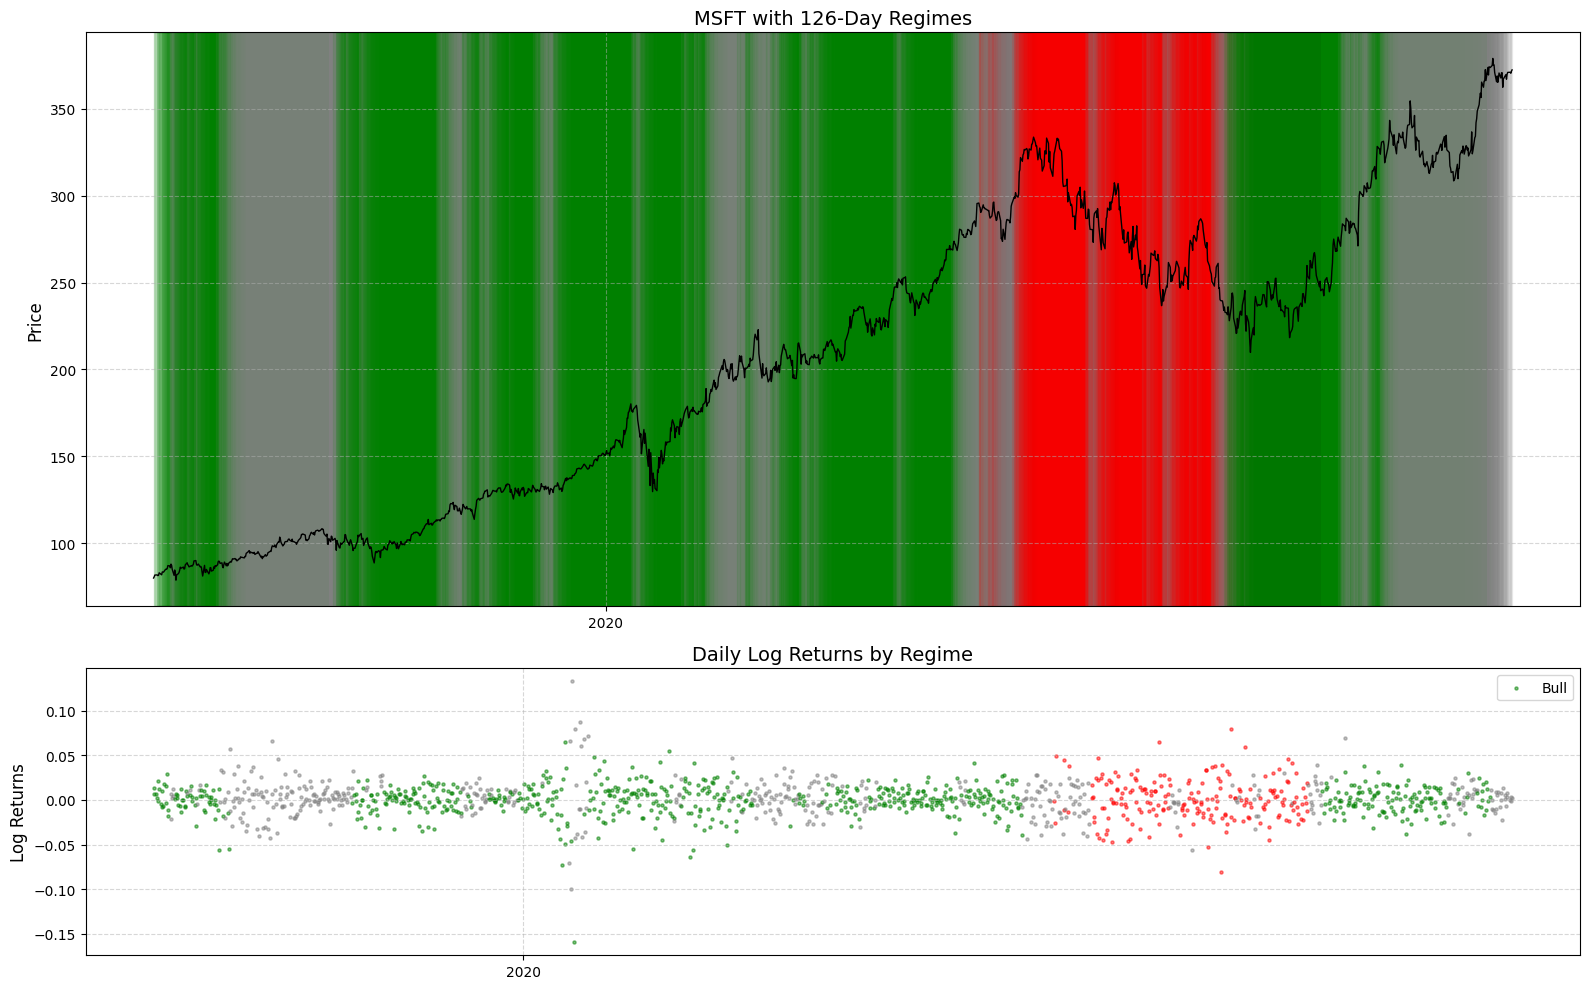

In [8]:
print("\nRunning enhanced regime detection...")
regime_labels, windows, _ = detect_regimes(data, window_size=126)  # 6-month windows
plot_regime_results(data, regime_labels, window_size=126)
    
